# Initialization
Import modules and define useful plotting functions

In [1]:
%matplotlib notebook 
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import integrate
import glob,sys

from mpl_toolkits.basemap import Basemap, shiftgrid

import MV2 as MV
import cdms2 as cdms
import genutil
import cdutil
import cdtime

sys.path.append("/Users/kmarvel/Google Drive/python-utils")
import Plotting


def bmap(X,projection="moll",**kwargs):
    """ quick plot of data on a lat,lon grid """
   # lon = X.getLongitude()[:]
    #lat = X.getLatitude()[:]
    
    lon = X.getLongitude().getBounds()[:,0]
    lat = X.getLatitude().getBounds()[:,0]
    vmin=None
    vmax=None
    if "vmin" in kwargs.keys():
        vmin=kwargs.pop("vmin")
    if "vmax" in kwargs.keys():
        vmax=kwargs.pop("vmax")
    if not ("lon_0" in list(kwargs.keys())):
        lon_0=np.median(lon)
    else:
        lon_0=kwargs.pop("lon_0")
        X,lon = shiftgrid(180,X,lon,start=False)
    m = Basemap(lon_0=lon_0,projection=projection,**kwargs)
    
        
    x,y=m(*np.meshgrid(lon,lat))
    #if vmin is None:
    #m.pcolormesh(x,y,X,**kwargs)
    #else:
    m.pcolor(x,y,X,vmin=vmin,vmax=vmax)
    return m

surface = {"hfls": "Surface Upward Latent Heat Flux",\
            "hfss": "Surface Upward Sensible Heat Flux",\
            "rlds":"Surface Downwelling Longwave Radiation",\
            "rlus":"Surface Upwelling Longwave Radiation",\
            "rsds":"Surface Downwelling Shortwave Radiation",\
            "rsus": "Surface Upwelling Shortwave Radiation"}
TOA = {"rsdt":"TOA Incident Shortwave Radiation",\
       "rsut": "TOA Outgoing Shortwave Radiation",\
       "rlut": "TOA Outgoing Longwave Radiation"}

# Data entry from RFMIP LGM experiments
Can also find info at https://cmip6workshop19.sciencesconf.org/data/Session2_PosterSlides.pdf

In [2]:
model="IPSL-CM6A-LR"
#model="CESM2"
#model_lgm_id="CESM2"
#model_lgm_id="ipsl-glac1d"
model_lgm_id="ipsl-ice6g"
#datadirec="/Users/kmarvel/Documents/DATA/LGM/LGM-Adjustments/"+model_lgm_id+"/"
#MODIFY rootstem depending on where you are
rootstem="/Volumes/SahelData/LGM/"
datadirec=rootstem+"LGM-Adjustments/"+model_lgm_id+"/"
pidirec=rootstem+"ProcessedFromMary/"+model+"/piControl/TimeMeans/"
#datadirec="/Users/kmarvel/Documents/DATA/LGM/LGM-Adjustments/ipsl-ice6g/"

## Top-of-atmosphere variables

In [3]:
f=cdms.open(glob.glob(datadirec+"rsdt_*")[0])

rsdt=f("rsdt")

f.close()

f=cdms.open(glob.glob(datadirec+"rsut_*")[0])

rsut=f("rsut")

f.close()

f=cdms.open(glob.glob(datadirec+"rlut_*")[0])

rlut=f("rlut")

f.close()

TOA = rsdt-(rsut+rlut)

print("TOA imbalance is ", MV.average(cdutil.averager(TOA,axis='xy')))

f=cdms.open(glob.glob(datadirec+"ts_*")[0])

ts=f("ts")

f.close()

## Clear-sky fluxes

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


TOA imbalance is  -3.0175962397159917


## Clear-sky fluxes

In [4]:
#f=cdms.open(glob.glob(datadirec+"rsdtcs_*")[0])

#rsdtcs=f("rsdtcs")

#f.close()

f=cdms.open(glob.glob(datadirec+"rsutcs_*")[0])

rsutcs=f("rsutcs")

f.close()

f=cdms.open(glob.glob(datadirec+"rlutcs_*")[0])

rlutcs=f("rlutcs")

f.close()



SWCRE = (rsutcs-rsut)
LWCRE = (rlutcs-rlut)

#sanity check on the climatologies
print("SWCRE", MV.average(cdutil.averager(SWCRE,axis='xy'),axis=0))
print("LWCRE", MV.average(cdutil.averager(LWCRE,axis='xy'),axis=0))

SWCRE -47.40987583973462
LWCRE 25.659177387447844


## Cloud cover

In [5]:
f=cdms.open(glob.glob(datadirec+"clt_*")[0])

clt=f("clt")

f.close()

#f=cdms.open(glob.glob(datadirec+"clcalipso_*")[0])

#clcalipso=f("clcalipso")
#clisccp=f("clisccp")

#f.close()

Sanity check: does the cloud cover look ok?

<IPython.core.display.Javascript object>


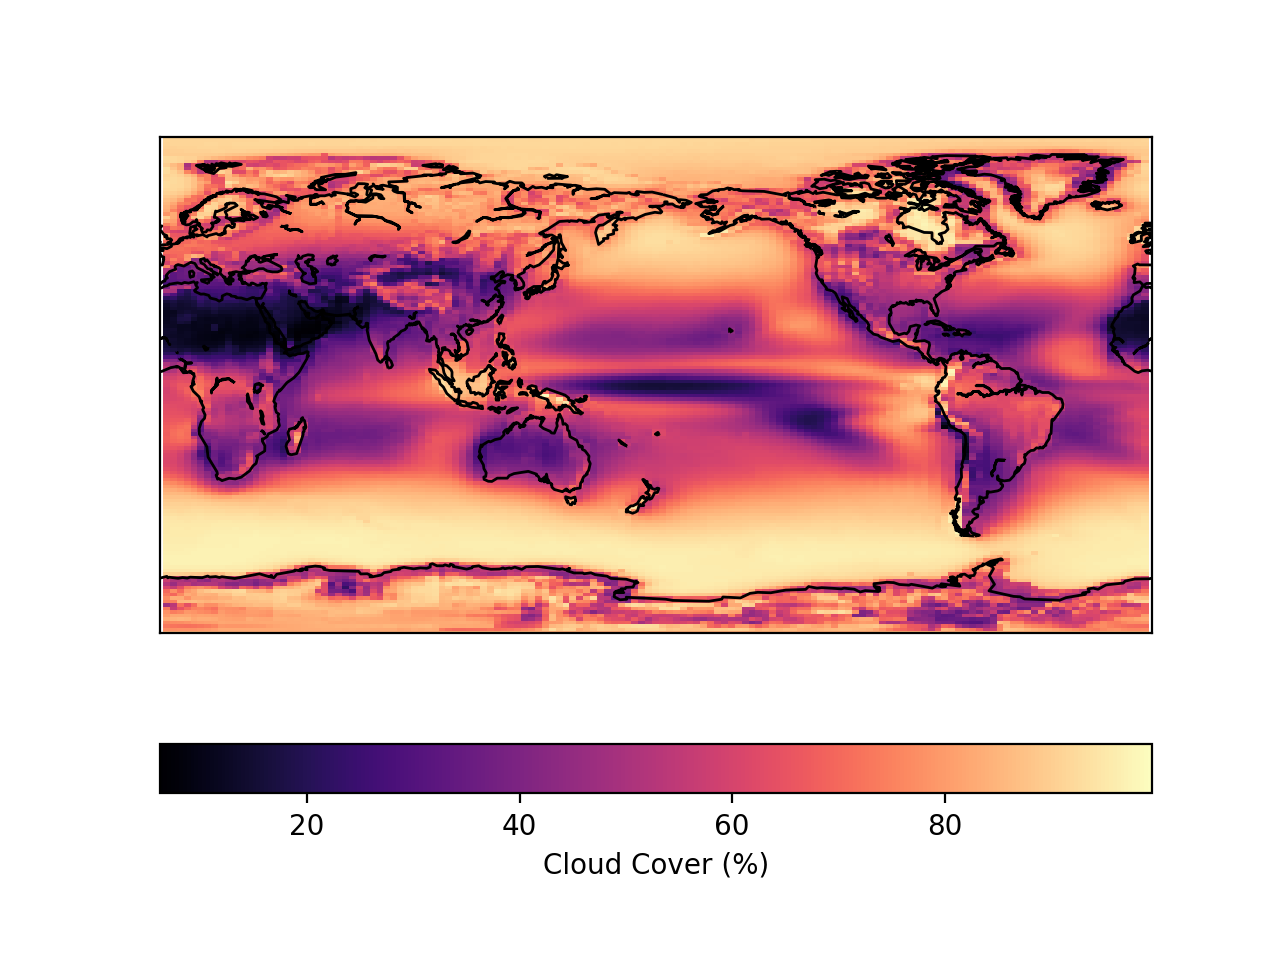

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [22]:
plt.set_cmap(cm.magma)
plt.figure()
m=bmap(MV.average(clt,axis=0),projection="cyl")
m.drawcoastlines()
cbar=plt.colorbar(orientation="horizontal",label="Cloud Cover (%)")

## Preindustrial control data

In [7]:
#model="IPSL-CM6A-LR"
model="CESM2"
#pidirec="/Users/kmarvel/Documents/DATA/LGM/ProcessedFromMary/"+model+"/piControl/TimeMeans/"
#pidirec="/Users/kmarvel/Documents/DATA/LGM/TimeMeans/"
#histdirec="/Users/kmarvel/Documents/DATA/LGM/ProcessedFromMary/"+model+"/historical/TimeMeans/"


#Kludge: use rsdt from LGM since it's not available for piControl.  
#rsdt_mean=MV.average(rsdt,axis=0)
#frsdt= cdms.open(histdirec+"rsdt_timemean.nc")
#rsdt_pi=frsdt("rsdt")
#rsdt_pi=MV.average(rsdt,axis=0)
if model=="CESM2":
    #rsdt_pi=rsdt_pi.regrid(rsdt.getGrid(),regridTool='regrid2')
#frsdt.close()
    frsdt=cdms.open(pidirec.replace("piControl","historical")+"rsdt_timemean.nc")
    rsdt_pi=frsdt("rsdt")
    frsdt.close()
else:
    rsdt_pi=MV.average(rsdt,axis=0)

frsut=cdms.open(pidirec+"rsut_timemean.nc")
rsut_pi=frsut("rsut")
frsut.close()
frlut=cdms.open(pidirec+"rlut_timemean.nc")
rlut_pi=frlut("rlut")
frlut.close()

frsutcs=cdms.open(pidirec+"rsutcs_timemean.nc")
rsutcs_pi=frsutcs("rsutcs")
frsutcs.close()

frlutcs=cdms.open(pidirec+"rlutcs_timemean.nc")
rlutcs_pi=frlutcs("rlutcs")
frlutcs.close()

fts=cdms.open(pidirec+"ts_timemean.nc")
ts_pi=fts("ts")
fts.close()

TOA_LGM=MV.average(TOA,axis=0)


TOA_pi = rsdt_pi-(rsut_pi+rlut_pi)


## TOA imbalance in the pre-industrial runs (why is it nonzero?)

In [8]:
print("TOA imbalance in the preindustrial is", float(cdutil.averager(TOA_pi,axis='xy')), "Wm-2")

TOA imbalance in the preindustrial is 0.6839974269198607 Wm-2


# Net TOA imbalance

In [9]:
print("Net TOA imbalance ",cdutil.averager(TOA_LGM,axis='xy')-cdutil.averager(TOA_pi,axis='xy'))

Net TOA imbalance  -3.701593462426323


## Flux differences and cloud radiative effects
Huge reductions over the ice sheets, as expected.  

In [10]:
rsutcs_LGM=MV.average(rsutcs,axis=0)
rsut_LGM=MV.average(rsut,axis=0)
plt.figure()
m=bmap((rsut_LGM-rsut_pi),projection="cyl",lon_0=0)#,vmin=-50,vmax=50,lon_0=0)
m.drawcoastlines()
plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
tmp=plt.title(r'$\Delta$RSUTCS')

<IPython.core.display.Javascript object>

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [11]:
SWCRE_LGM=MV.average(SWCRE,axis=0)
SWCRE_piC=rsutcs_pi-rsut_pi
plt.figure()
m=bmap((SWCRE_LGM-SWCRE_piC),projection="moll",vmin=-50,vmax=50,lon_0=0)
m.drawcoastlines()
plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
tmp=plt.title(r'$\Delta$SWCRE')

<IPython.core.display.Javascript object>

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [12]:
LWCRE_LGM=MV.average(LWCRE,axis=0)
LWCRE_piC=rlutcs_pi-rlut_pi
plt.figure()
m=bmap((LWCRE_LGM-LWCRE_piC),projection="cyl",vmin=-20,vmax=20)
m.drawcoastlines()
cbar=plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
title=plt.title(r'$\Delta$LWCRE')

<IPython.core.display.Javascript object>

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [13]:
print("LGM SWCRE is ",cdutil.averager(SWCRE_LGM,axis='xy'))
print("piC SWCRE is ", cdutil.averager(SWCRE_piC,axis='xy'))
print("DIFF is", cdutil.averager(SWCRE_LGM,axis='xy')-cdutil.averager(SWCRE_piC,axis='xy'))

LGM SWCRE is  -47.40987566334179
piC SWCRE is  -49.24807478976397
DIFF is 1.8381991264221753


In [14]:
print("LGM LWCRE is ",cdutil.averager(LWCRE_LGM,axis='xy'))
print("piC LWCRE is ", cdutil.averager(LWCRE_piC,axis='xy'))
print("DIFF is", cdutil.averager(LWCRE_LGM,axis='xy')-cdutil.averager(LWCRE_piC,axis='xy'))

LGM LWCRE is  25.659177447686663
piC LWCRE is  25.90206852747305
DIFF is -0.24289107978638924


In [15]:
ts_LGM=MV.average(ts,axis=0)
dTs=ts_LGM-ts_pi
plt.figure()
bmap(dTs,projection='cyl',vmin=-5,vmax=5)
plt.colorbar()

<IPython.core.display.Javascript object>

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [16]:
print("Land cooling is",float(cdutil.averager(dTs,axis='xy')),"K")

Land cooling is -1.6604717998697383 K


In [17]:
IPSL_ECS=4.7
IPSL_F2CO2=3.23
IPSL_lam=IPSL_F2CO2/IPSL_ECS
IPSL_lam

0.6872340425531914

In [18]:
ERF_LGM = TOA_LGM-TOA_pi+dTs*IPSL_lam
plt.figure()
m=bmap(ERF_LGM,projection="cyl",lon_0=0,vmin=-30,vmax=30)
cbar=plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
title=plt.title("LGM ERF")

<IPython.core.display.Javascript object>

/Users/kmarvel/anaconda3/envs/cdat_plus/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [19]:
print("ERF of the LGM is",cdutil.averager(ERF_LGM,axis='xy'),"Wm-2")

ERF of the LGM is -4.842726183907815 Wm-2


In [20]:
def erf_lam(lam):
    ERF_LGM = TOA_LGM-TOA_pi+dTs*lam
    return float(cdutil.averager(ERF_LGM,axis='xy'))
erf_lam(3.7/2.)

-6.773466266096777

Cooling in IPSL_CM5 (from ftp://oceane.obs-vlfr.fr/pub/lguidi/PRIME/Pubs/kageyama%202012%20part%201.pdf): -4.48K so, assuming unit efficacy of ice sheet forcing we have (need to check 2xCO2 forcing in IPSL):

## ERF of the IPSL-CM6A-LR MODEL

In [23]:
print("ERF is ",cdutil.averager(ERF_LGM,axis='xy'),"W m-2")
ERF_avg=cdutil.averager(ERF_LGM,axis='xy')


ERF is  -4.842726183907815 W m-2


In [24]:
f=cdms.open("/Volumes/SahelData/LGM/LGM-Adjustments/ipsl-glac1d/clcalipso_CFmon_IPSL-CM6A-LR_piClim-lgmMask-isH1D-ghgOp_r1i1p1f1_gr_201401-204312.nc")
clcalipso=f("clcalipso")

KeyboardInterrupt: 

In [ ]:
#calculate a time mean of clcalipso (on laptop)
fp=cdms.open("/Users/kmarvel/Documents/DATA/LGM/piControl/clcalipso_CFmon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_285001-304912.nc")
clcalipso_piC=fp["clcalipso"][-240:]
clcalipso_piC_clim=MV.average(clcalipso_piC,axis=0)
fp.close()


In [ ]:
clcalipso_piC_clim=MV.average(clcalipso_piC,axis=0)
deltaclcalipso=MV.average(clcalipso,axis=0)-clcalipso_piC_clim

In [ ]:
plt.figure()
m=bmap(MV.average(deltaclcalipso[:10],axis=0),projection="cyl",vmin=-5,vmax=5,lon_0=0)
plt.colorbar(orientation='horizontal',label="%")
m.drawcoastlines()
tmp=plt.title("Low cloud changes")


plt.figure()
m=bmap(MV.average(deltaclcalipso[-20:],axis=0),projection="cyl",vmin=-3,vmax=3,lon_0=0)
plt.colorbar(orientation='horizontal',label="%")
m.drawcoastlines()
tmp=plt.title("High cloud changes")

In [30]:
#get abrupt0p5CO2 data
#0.5 toa
def get_abrupt(variable,model="GISS-E2-1-G",factor="0p5"):
    #abrupt0p5direc="/Users/kmarvel/Documents/DATA/LGM/abrupt-0p5xCO2/"+model+"/"
    abrupt0p5direc=rootstem+"abrupt-"+factor+"xCO2/"+model+"/"
    vfiles=sorted(glob.glob(abrupt0p5direc+"*"+variable+"*"))
    fv=cdms.open(vfiles[0])
    data=cdutil.averager(fv(variable),axis='xy')
    fv.close()
    if len(vfiles)>1:
        for fil in vfiles[1:]:
            fv=cdms.open(fil)
            mdata=cdutil.averager(fv(variable),axis='xy')
            data=MV.concatenate((data,mdata))
            fv.close()

    cdutil.setTimeBoundsMonthly(data)
    return data

In [25]:
rsdt0p5=get_abrupt("rsdt",model="IPSL-CM6A-LR")
rsut0p5=get_abrupt("rsut",model="IPSL-CM6A-LR")
rlut0p5=get_abrupt("rlut",model="IPSL-CM6A-LR")
TOA0p5=rsdt0p5-(rsut0p5+rlut0p5)
T0p5=get_abrupt("tas",model="IPSL-CM6A-LR")-273.15

In [31]:
rsdt4=get_abrupt("rsdt",model="IPSL-CM6A-LR",factor="4")
rsut4=get_abrupt("rsut",model="IPSL-CM6A-LR",factor="4")
rlut4=get_abrupt("rlut",model="IPSL-CM6A-LR",factor="4")
TOA4=rsdt4-(rsut4+rlut4)
T4=get_abrupt("tas",model="IPSL-CM6A-LR",factor="4")-273.15

<IPython.core.display.Javascript object>


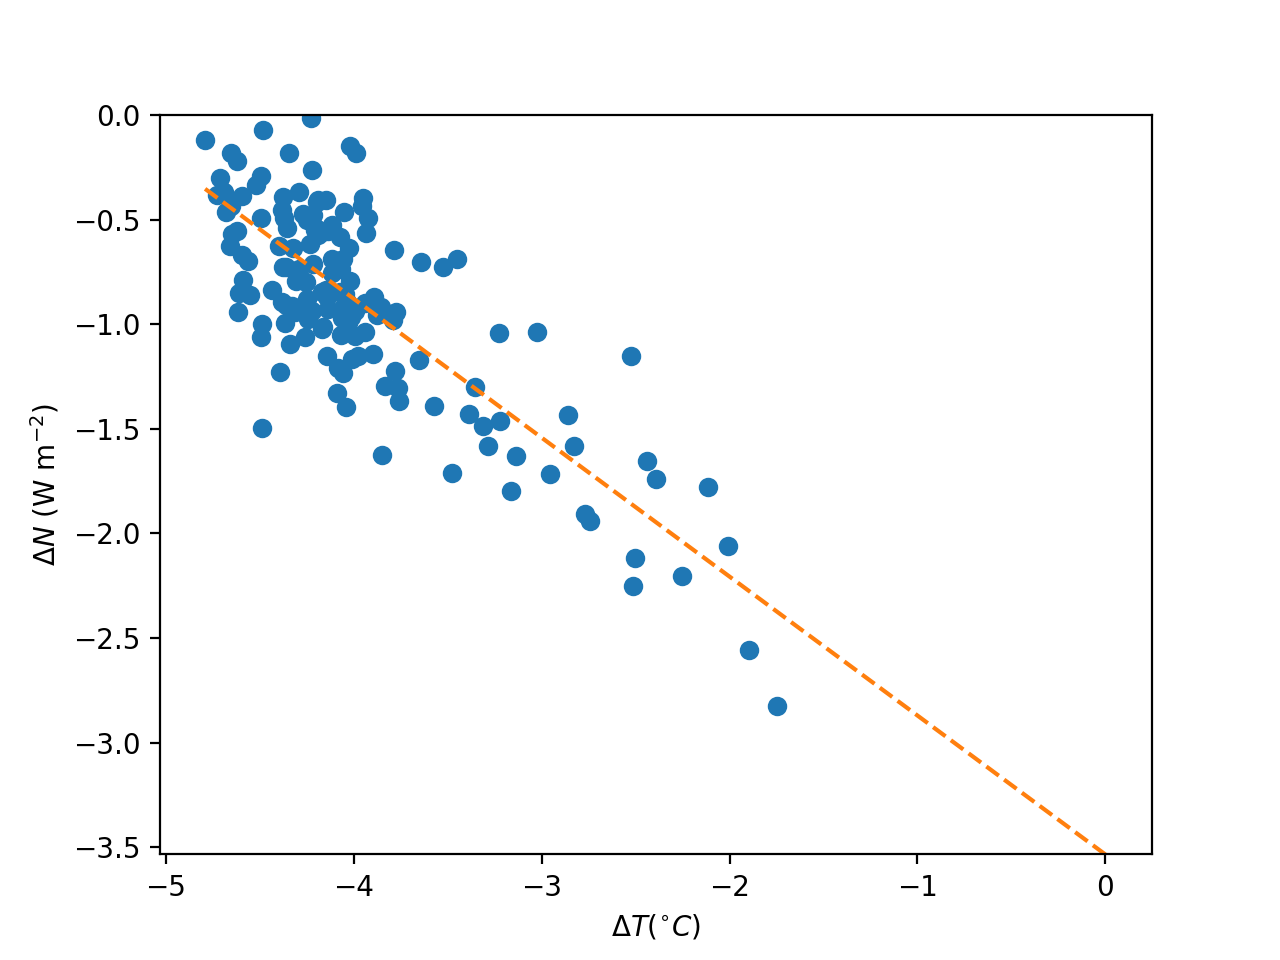

In [38]:
y=cdutil.YEAR(TOA0p5)-cdutil.averager(TOA_pi,axis='xy')
x=cdutil.YEAR(T0p5+273.15)-cdutil.averager(ts_pi,axis='xy')


plt.figure()
plt.plot(x.asma(),y.asma(),"o")
p=np.polyfit(x,y,1)
xn=np.arange(np.min(x),0.1,.1)
plt.plot(xn,np.polyval(p,xn),ls="--")
xlab=plt.xlabel(r'$\Delta T (^{\circ}C)$')
ylab=plt.ylabel(r'$\Delta N$ (W m$^{-2})$')
np.polyval(p,0.)
#plt.xlim(-3.2,0)
plt.ylim(p[1],0)

plt.savefig("/Users/kmarvel/Desktop/A0p5CO2.png")
lam,Fcing=p
ECS0p5=Fcing/-lam


<IPython.core.display.Javascript object>


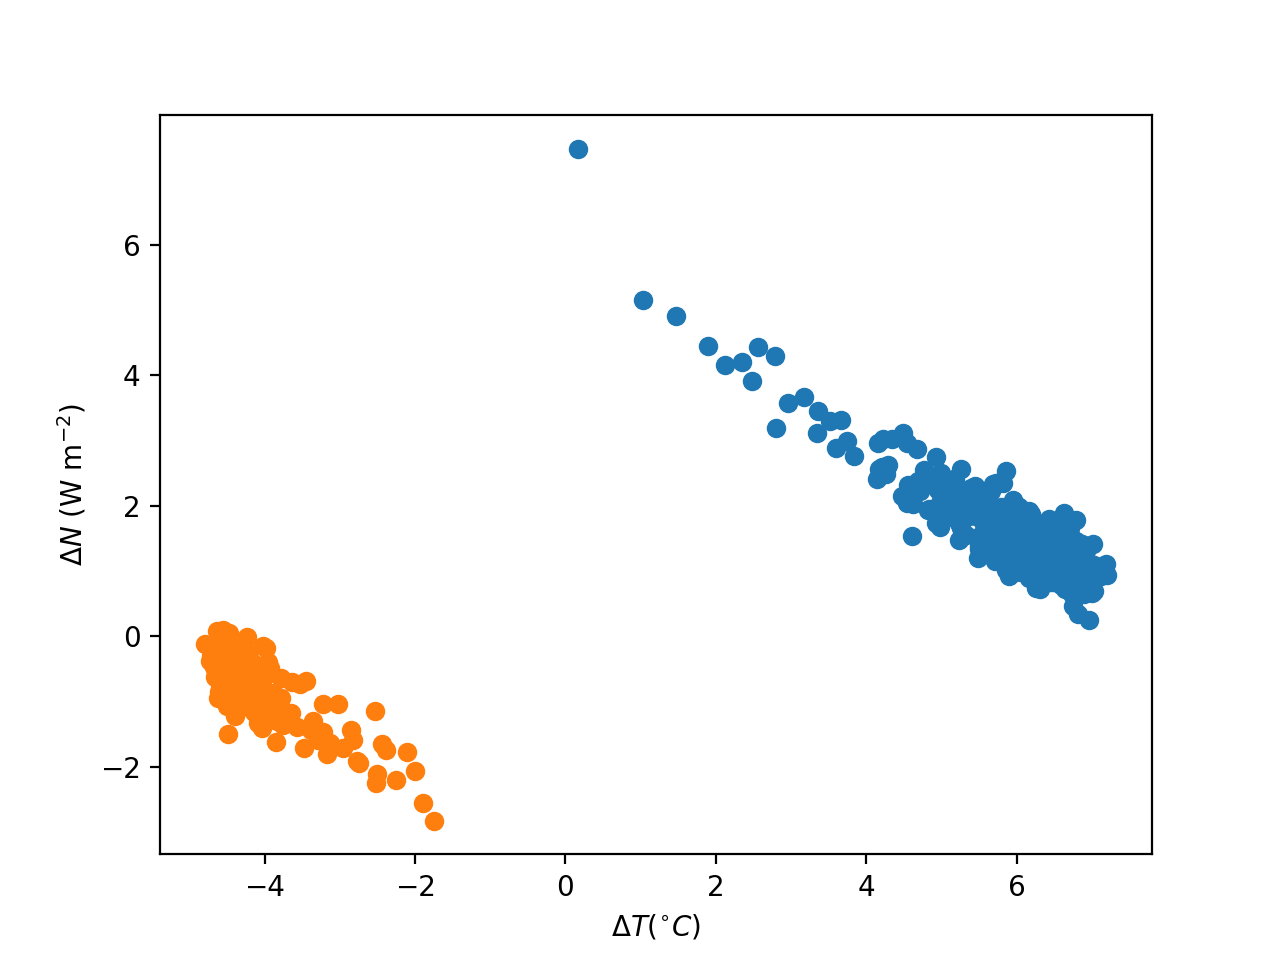

In [44]:
y4=cdutil.YEAR(TOA4)-cdutil.averager(TOA_pi,axis='xy')
x4=cdutil.YEAR(T4+273.15)-cdutil.averager(ts_pi,axis='xy')


plt.figure()
plt.plot(x4.asma(),y4.asma(),"o",label="4xCO2")
plt.plot(x.asma(),y.asma(),"o",label="0.5xCO2")
p=np.polyfit(x4,y4,1)
xn=np.arange(np.min(x4),0.1,.1)
plt.plot(xn,np.polyval(p,xn),ls="--")
xlab=plt.xlabel(r'$\Delta T (^{\circ}C)$')
ylab=plt.ylabel(r'$\Delta N$ (W m$^{-2})$')
np.polyval(p,0.)
#plt.xlim(-3.2,0)
#plt.ylim(p[1],0)


lam4,Fcing4=p
ECS4x=0.5*Fcing4/-lam4

In [27]:
print("1/2 CO2 forcing is", Fcing)
print("1/2 CO2 ECS is", ECS0p5)

1/2 CO2 forcing is -3.5348899887055043
1/2 CO2 ECS is -5.321391587832291


In [43]:
print("4x CO2 ECS is ",ECS4x)
print("4x CO2 forcing is ",Fcing4/2.)

4x CO2 ECS is  4.145758499334304
4x CO2 forcing is  2.8202942505439594


<IPython.core.display.Javascript object>


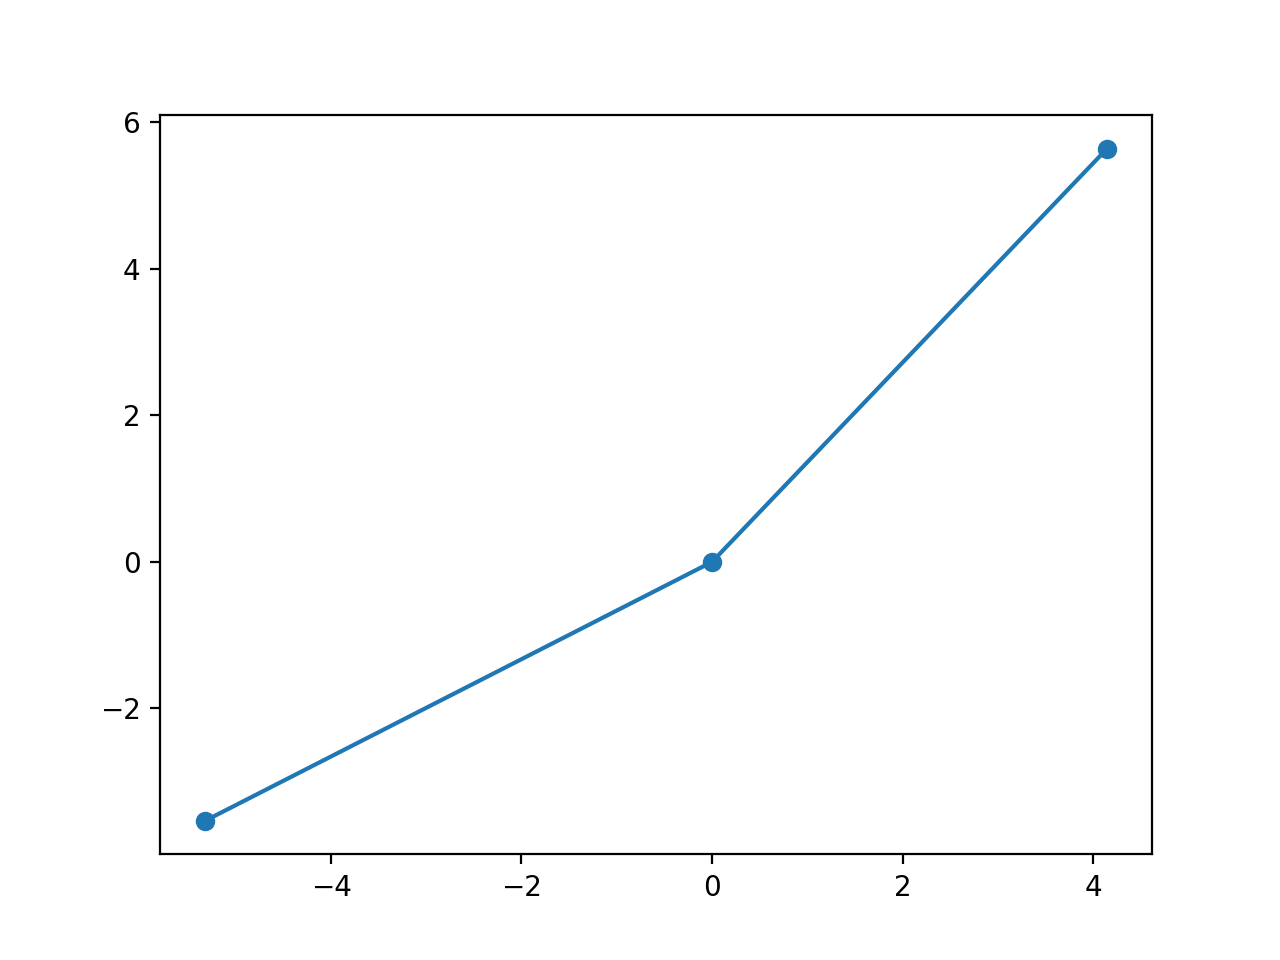

array([ 7.35479280e-02,  1.05565657e+00, -1.02558010e-15])

In [46]:
parax=[ECS0p5,0,ECS4x]
paray=[Fcing,0,Fcing4]
plt.figure()
plt.plot(parax,paray,"o-")
pstate=np.polyfit(parax,paray,2)
pstate

In [ ]:
def write_annualcycle(variable):
    f=cdms.open(glob.glob(datadirec+variable+"_*")[0])

    LGM=f(variable)

    f.close()


    LGM_ac=cdutil.ANNUALCYCLE.climatology(LGM)

    LGM_ac.id=variable

    fw=cdms.open(rootstem+"ClimatologiesForKernels/"+variable+".IPSL-CM6A-LR.LGM.nc","w")
    fw.write(LGM_ac)
    fw.close()

In [ ]:
def write_annualcycle_piControl(variable):

    f=cdms.open(glob.glob("/Users/kmarvel/Downloads/"+variable+"_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_285001-304912.nc")[0])

    piC=f(variable)

    f.close()


    piC_ac=cdutil.ANNUALCYCLE.climatology(piC)

    piC_ac.id=variable

    fw=cdms.open(rootstem+"ClimatologiesForKernels/"+variable+".IPSL-CM6A-LR.piControl.nc","w")
    fw.write(piC_ac)
    fw.close()

In [ ]:
def get_vertical_adjustments(variable,kernel_type):
    variable="ta"
    kernel_type="lw_t"
    #fkernels=cdms.open("/Users/kmarvel/Documents/DATA/LGM/kernels/HadGEM3-GA7.1_TOA_kernel.nc")
    fkernels=cdms.open(rootstem+"kernels/TOA_CloudSat_Kerns.nc")
    #fkernels=cdms.open("/Users/kmarvel/Documents/DATA/LGM/kernels/HadGEM2_lw_TOA_L38.nc")
    thekernel=fkernels(kernel_type)
    fkernels.close()
    f_LGM=cdms.open(rootstem+"ClimatologiesForKernels/"+variable+".IPSL-CM6A-LR.LGM.nc")
    f_piC=cdms.open(rootstem+"ClimatologiesForKernels/"+variable+".IPSL-CM6A-LR.piControl.nc")
    LGM_ac=f_LGM(variable)
    piC_ac=f_piC(variable)
    delta_ac=LGM_ac-piC_ac
    thekernel_regrid=thekernel.regrid(LGM_ac.getGrid(),regridTool='esmf')
    thekernel_pressureregrid=thekernel_regrid.pressureRegrid(LGM_ac.getLevel())
    adjustments_vertical=MV.average(thekernel_pressureregrid*delta_ac,axis=0)
    return adjustments_vertical

In [ ]:
plt.figure()
m=bmap(MV.sum(adjustments_vertical,axis=0),projection="cyl",lon_0=0,vmin=-4,vmax=4)
m.drawcoastlines()
plt.colorbar(orientation='horizontal')


In [ ]:
np.diff(delta_ac.getLevel()[:])

In [ ]:
zonal=cdutil.averager(MV.average(delta_ac,axis=0),axis='x')

In [ ]:
xm,ym=np.meshgrid(zonal.getLatitude()[:],zonal.getLevel()[:])
plt.pcolormesh(xm,ym,zonal.asma())
plt.colorbar()

In [ ]:
fkernel=cdms.open("/Users/kmarvel/Documents/DATA/LGM/kernels/TOA_CloudSat_Kerns.nc")
fkernel["lw_t"]

In [ ]:
variable="hus"
f=cdms.open(glob.glob("/Users/kmarvel/Downloads/"+variable+"_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_285001-304912.nc")[0])
f["hus"].units